# Tutorial 2: Recover true GB1 MAVE-NN GE model using simulated data

In this tutorial notebook, we will use MAVE-NN to train a global epistasis model with an additive genotype-phenotype (G-P) map on GB1 DMS data from (Olson et al. (2014)). We will then use this model to generated simulated GB1 data and show that MAVE-NN can recover the original model using simulated data.

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# For showing images
from IPython.display import Image

# # Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn

In Olson et al., a library of variant GB1 proteins (colored bells), comprising all single and pairwise mutations, were covalently linked to their coding mRNAs (gray wavy lines) using mRNA display. Functional GB1 proteins were then enriched using IgG beads, and deep sequencing was used to determine an enrichment ratio for each GB1 variant.

<img src="GB1.png" alt="GB1 experiment" style="width: 700px;"/>

The resulting data can be obtained by calling MAVE-NN's `load_example_dataset` method with the input string "`gb1`", and are in the form of a pandas dataframe: 

In [2]:
# Load example data
data_df = mavenn.load_example_dataset(name='gb1')
data_df.head(10)

,set,input_ct,selected_ct,y,x
0,training,73.0,62.0,-1.021847,QYKLILNGKTLKGETTTEAHDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,122.0,0.0,-7.732188,QYKLILNGKTLKGETTTEAVDAATAEKVFPQYANDNGVDGEWTYDD...
2,training,794.0,598.0,-1.198072,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANKNGVDGEWTLDD...
3,training,1115.0,595.0,-1.694626,QYKLILNIKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDS...
4,validation,97.0,2.0,-5.819421,QYKLINNGKTLKGETTTEAVDAATAEKVFKIYANDNGVDGEWTYDD...
5,training,40.0,169.0,1.262166,QYKLILNGKTLWGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,244.0,819.0,0.953169,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYVV...
7,training,381.0,232.0,-1.502916,QYKLILNGKTLKGAFTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,366.0,5.0,-6.724347,QYKLILNGKTLKGETTTEAVDAVTHEKVFKQYANDNGVDGEWTYDD...
9,training,119.0,145.0,-0.506739,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANENGVDGEWTYDD...


The set column in MAVE-NN example dataset dataframes can be used to split sequences into training/validation/test sets.

In [3]:
# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'Number of test sequences: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'Sequences to be used for training + validation N: {len(data_df):,}')

Number of test sequences: 106,336
Sequences to be used for training + validation N: 424,401


We now define a MAVE-NN model with an additive G-P map and a Gaussian noise model. 

In [4]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(L=L,
                     alphabet='protein',
                     gpmap_type='additive', 
                     regression_type='GE',
                     ge_noise_model_type='Gaussian',
                     ge_heteroskedasticity_order=2)


The additive G-P of this model is defined as 
$$ \phi(x) = \theta_0 + \sum_{l,c} \theta_{l:c} x_{l:c},$$

where $l$ indexes positions in the sequence, $c$ indexes characters from the alphabet, and $x_{l:c}$ is an indicator variable equal to 1 when $c$ occurs at position $l$, and equal to 0 otherwise. The parameters of this model $\theta_0, \theta_{l:c}$ are to be learned from data. 

`regression_type='GE'`: This indicates that we want to perform global epistasis (GE) regression. The key assumption of GE regression is that each measurement $y$ is a noisy readout of a predicte mesurement $\hat{y}$, which itself is a nonlinear function $g$ of the latent phenotype $\phi$. Thus,

$$ p(y | \phi) = p(y|\hat{y})~~\mathrm{where}~~\hat{y} = g(\phi).$$

The nonlinear function $g(\phi)$ is to be learned from data using a two-layer neural network having a default value of `ge_nonlinearity_hidden_nodes=50` hidden nodes. `ge_noise_model_type='Gaussian'`: This indicates that we wish for our noise model, $p(y|\hat{y})$, to be a Gaussian distribution, $$p(y|\hat{y};s) = \frac{1}{\sqrt{2 \pi s^2}} \exp \Big[-\frac{(y-\hat{y})^2}{2s^2} \Big]. $$

`ge_heteroskedasticitiy_order=2`: This indicates that we are using a heteroskedastic model. Specifically, we model the standard deviation $s$ of $p(y|\hat{y})$  an expoentiated quadratic polynomial in $\hat{y}$, as in tutorial 1.

To fit this model to training data, we set the data that will be used for training the model by calling the `set_data` method. Note that we have specified the validation set by using the `validation_flags` argument.

In [5]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

N = 424,401 observations set as training data.
Using 24.9% for validation.
Data shuffled.
Time to set data: 16.2 sec.


Calling the `fit` methods fits this model to these data by minimizating the negative log likelihood, given by: $$\mathcal{L}_{\text{like}}[\vec{\theta},\vec{\eta}] = -\sum_{n=1}^{N-1} \log[p(y_n|\phi_n, \vec{\eta})].$$
Here $\vec{\eta}$ represents a vector which contains the parameters of the GE nonlinear function $g(\phi)$ and the noise model $p(y|\hat{y})$.

In [6]:
# Fit model to data
history = model.fit(learning_rate=.0005,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/1000
319/319 [==============================] - 3s 11ms/step - loss: 1263.7616 - I_var: -0.0599 - val_loss: 974.7684 - val_I_var: 0.3551
Epoch 2/1000
319/319 [==============================] - 3s 8ms/step - loss: 682.3325 - I_var: 0.7821 - val_loss: 416.7107 - val_I_var: 1.1658
Epoch 3/1000
319/319 [==============================] - 3s 8ms/step - loss: 232.6340 - I_var: 1.4347 - val_loss: 114.0902 - val_I_var: 1.6067
Epoch 4/1000
319/319 [==============================] - 3s 8ms/step - loss: 44.0267 - I_var: 1.7099 - val_loss: -12.8209 - val_I_var: 1.7926
Epoch 5/1000
319/319 [==============================] - 3s 8ms/step - loss: -42.1313 - I_var: 1.8361 - val_loss: -47.6648 - val_I_var: 1.8446
Epoch 6/1000
319/319 [==============================] - 3s 8ms/step - loss: -90.2360 - I_var: 1.9067 - val_loss: -103.4723 - val_I_var: 1.9264
Epoch 7/1000
319/319 [==============================] - 3s 8ms/step - loss: -119.9029 - I_var: 1.9504 - val_loss: -134.0670 - val_I_var: 1.9715
E

Every MAVE-NN model can be saved and loaded using MAVE-NN's `save` and `load` methods.

In [7]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [8]:
model = mavenn.load('gb1_ge_additive')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


Next, we look at our model's training history and compute some metrics to determine how well we have fit the model to data. Specifically, we plot the variational information against epochs, $$ I_{\text{var}}[y;\phi] = H[y]- \frac{\log_2(e)}{N}\mathcal{L}_{\text{like}}.$$

We also compute the predictive information (on test data) $ I_{\text{pred}}[y;\phi] $. Variational information serves as an approximate lower bound for the predictive information, and the two can be related as $$ I_{\text{pred}}[y;\phi]-I_{\text{var}}[y;\phi] \approx \text{D}_{\text{KL}}(p_{\text{true}}||p_{\text{model}}) $$


On test data:
I_var_test: 2.075 +- 0.009 bits
I_pred_test: 2.180 +- 0.004 bits


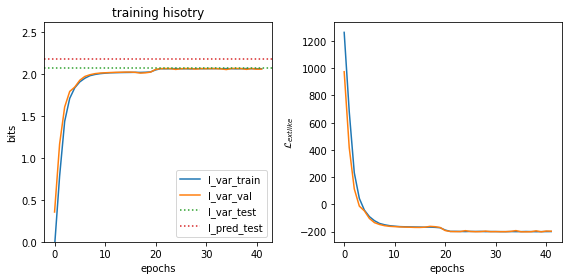

In [9]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,2,figsize=[8,4])
ax[0].plot(I_var_hist, label='I_var_train')
ax[0].plot(val_I_var_hist, label='I_var_val')
ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('bits')
ax[0].set_title('training hisotry')
ax[0].set_ylim([0, I_pred*1.2]);

ax[1].plot(model.history['loss'])
ax[1].plot(model.history['val_loss'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

plt.tight_layout()

We can compute predictions $\hat{y}$ on test by calling the `x_to_yhat` method, and plot $y$ against $\hat{y}$ and compute the corresponding $R^2$ value.

Text(0.5, 1.0, 'performance ($R^2$=0.94)')

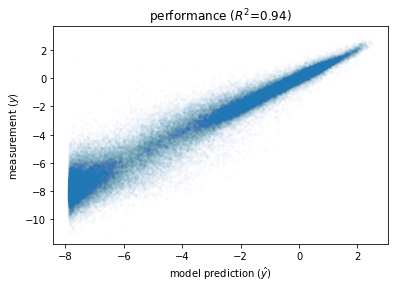

In [10]:
# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

# Plot y_test vs. yhat_test
fig, ax = plt.subplots(1,1)
ax.scatter(yhat_test, y_test, color='C0', s=5, alpha=.01, label='test data')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'performance ($R^2$={Rsq:.3})')

We can plot the GE nonlinearity $g(\phi)$ by creating a grid of $\phi$ values and mapping these to $\hat{y}$ values using `model.phi_to_yhat()`. We can plot confidence intervals of $p(y|\hat{y})$ using the function `model.yhat_to_yq()`.

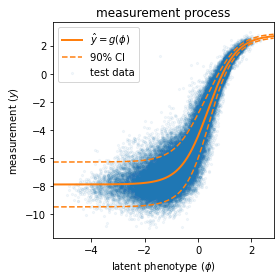

In [11]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.05, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

We can visualize the parameters of the G-P map by calling `mavenn.heatmap`

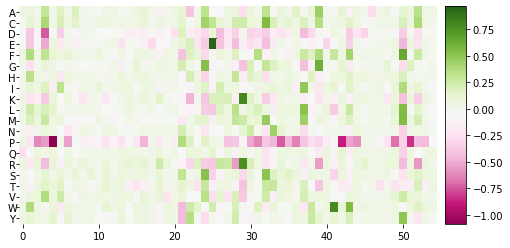

In [12]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap(values=theta['theta_lc'],
                        alphabet=theta['alphabet'],
                        ax=ax,
                        cmap='PiYG');

Store $\vec{\theta}$ in a variable for comparison later.

In [13]:
theta_lc = model.get_theta()['theta_lc']

## Recover true model from simulated data

Next we will simulate GB1 data using MAVE-NN's `simulate_dataset`, and then train a separate MAVE-NN GE model to check if we can recover the original model. The original dataset contains approximately 500,000 samples, we will simulate far fewer sequences and still be able to recover the underlying model. `simulate_dataset` generates sequences according to the probability matrix $p_{l:c}$, which represents the probability of character $c$ at position $l$ and is computed using the one-hot encoded representation of the training sequences.

In [14]:
# Test simulate_data
sim_df = model.simulate_dataset(N=100000)
sim_df.head()

,set,yhat,phi,y,x
0,test,-6.608096,-0.646814,-6.670483,QYKLILNGKTLKGTTTTEAVDAATAEKVFKQYAKDNGVDGEWTYDD...
1,validation,-2.640099,0.365177,-3.716023,QYKLILNGKTLMGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,-0.817694,0.730337,-0.594123,QYKLILNGKTLKGETTTEAKDAATAEHVFKQYANDNGVDGEWTYDD...
3,training,-7.807747,-2.126831,-6.338431,QYKLILNGKTLKGEMTTEAVDAATAEKVFKQTANDRGVDGELTYDD...
4,validation,-7.601037,-1.473872,-5.978342,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEDTYDD...


`simulate_dataset` returns simulated data in a pandas dataframe, exactly in the format of dataframe returned by the `load_example_dataset` method. We define a new MAVE-NN model which will be trained using simulated data.

In [15]:
sim_model = mavenn.Model(L=L,
                     alphabet='protein',
                     gpmap_type='additive', 
                     regression_type='GE',
                     ge_noise_model_type='Gaussian',
                     ge_heteroskedasticity_order=2)

Next, we split sequences into training/validation/test sets and set training and validation data by using `set_data`.

In [16]:
# Separate test from data_df
ix_test = sim_df['set']=='test'
test_df = sim_df[ix_test].reset_index(drop=True)
print(f'Number of test sequences: {len(test_df):,}')

# Remove test data from data_df
sim_df = sim_df[~ix_test].reset_index(drop=True)
print(f'Sequences to be used for training + validation N: {len(sim_df):,}')

Number of test sequences: 20,009
Sequences to be used for training + validation N: 79,991


In [17]:
# Set training data
sim_model.set_data(x=sim_df['x'],
               y=sim_df['y'],
               validation_flags=(sim_df['set']=='validation'),
               shuffle=True)

N = 79,991 observations set as training data.
Using 25.1% for validation.
Data shuffled.
Time to set data: 1.98 sec.


We now fit the new model to these simulated data using the same parameters for the `fit` method as in the true model.

In [18]:
# Fit model to data
sim_model.fit(learning_rate=.0005,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/1000
60/60 [==============================] - 0s 8ms/step - loss: 1491.5593 - I_var: -0.1841 - val_loss: 1412.4099 - val_I_var: -0.0674
Epoch 2/1000
60/60 [==============================] - 0s 6ms/step - loss: 1408.1146 - I_var: -0.0640 - val_loss: 1400.2091 - val_I_var: -0.0503
Epoch 3/1000
60/60 [==============================] - 0s 7ms/step - loss: 1390.5842 - I_var: -0.0387 - val_loss: 1375.9402 - val_I_var: -0.0159
Epoch 4/1000
60/60 [==============================] - 0s 7ms/step - loss: 1356.4250 - I_var: 0.0111 - val_loss: 1330.2944 - val_I_var: 0.0492
Epoch 5/1000
60/60 [==============================] - 1s 10ms/step - loss: 1297.5345 - I_var: 0.0965 - val_loss: 1257.4968 - val_I_var: 0.1535
Epoch 6/1000
60/60 [==============================] - 1s 9ms/step - loss: 1210.6870 - I_var: 0.2230 - val_loss: 1156.8151 - val_I_var: 0.2986
Epoch 7/1000
60/60 [==============================] - 1s 9ms/step - loss: 1095.6639 - I_var: 0.3900 - val_loss: 1031.7521 - val_I_var: 0.4792

Epoch 59/1000
60/60 [==============================] - 1s 10ms/step - loss: -70.6130 - I_var: 2.0941 - val_loss: -65.8234 - val_I_var: 2.0797
Epoch 60/1000
60/60 [==============================] - 1s 12ms/step - loss: -71.2411 - I_var: 2.0949 - val_loss: -65.8293 - val_I_var: 2.0815
Epoch 61/1000
60/60 [==============================] - 1s 9ms/step - loss: -69.7432 - I_var: 2.0925 - val_loss: -63.0353 - val_I_var: 2.0788
Epoch 62/1000
60/60 [==============================] - 1s 10ms/step - loss: -71.7503 - I_var: 2.0955 - val_loss: -64.3145 - val_I_var: 2.0803
Epoch 63/1000
60/60 [==============================] - 1s 10ms/step - loss: -71.3283 - I_var: 2.0945 - val_loss: -67.1923 - val_I_var: 2.0826
Epoch 64/1000
60/60 [==============================] - 1s 10ms/step - loss: -72.2857 - I_var: 2.0962 - val_loss: -59.1356 - val_I_var: 2.0684
Epoch 65/1000
60/60 [==============================] - 1s 9ms/step - loss: -71.9456 - I_var: 2.0955 - val_loss: -67.1736 - val_I_var: 2.0829
Epoch 66

We use the model trained on simulated sequences to make predictions on test sequences from the original model so we can compare them using a scatter plot and compute $R^2$ values (see below).

In [19]:
# Predict latent phentoype values (phi) on test data
sim_phi_test = sim_model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
sim_yhat_test = sim_model.x_to_yhat(x_test)

We also get the parameters of the G-P from the new model so that we can compare them to the parameters of the G-P map of the model trained on real sequences.

In [20]:
sim_theta_lc = sim_model.get_theta()['theta_lc']

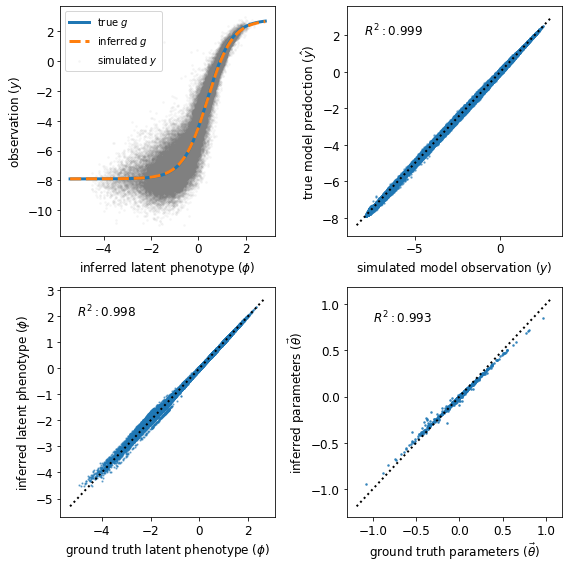

In [21]:
fig, ax = plt.subplots(2, 2, figsize=[8, 8])

# Compute yhat each phi gridpoint
sim_yhat_grid = sim_model.phi_to_yhat(phi_grid)

ax[0,0].plot(phi_grid,yhat_grid, lw=3, label='true $g$')
ax[0,0].plot(phi_grid,sim_yhat_grid, linestyle='--',lw=3, label='inferred $g$')
ax[0,0].scatter(sim_phi_test, y_test, color='gray', s=3, alpha=0.05, label ='simulated $y$')
ax[0,0].tick_params(labelsize=12)
ax[0,0].set_ylabel('observation ($y$)',fontsize=12)
ax[0,0].set_xlabel('inferred latent phenotype ($\phi$)',fontsize=12)
ax[0,0].legend()

Rsq_sim = np.corrcoef(sim_yhat_test, yhat_test)[0][1]**2
ax[0,1].scatter(sim_yhat_test,yhat_test,s=2,alpha=0.5)
lims = ax[0,1].get_xlim()
ax[0,1].plot(lims, lims, linestyle=':', color='k', label='$y=\hat{y}$', lw=2)
ax[0,1].text(-8,2,'$R^2: $'+str(Rsq_sim)[0:5],fontsize=12)
ax[0,1].set_ylabel('true model predoction ($\hat{y}$)',fontsize=12)
ax[0,1].set_xlabel('simulated model observation ($y$)',fontsize=12)
ax[0,1].tick_params(labelsize=12)


Rsq_phi_sim = np.corrcoef(phi_test, sim_phi_test)[0][1]**2
ax[1,0].scatter(phi_test,sim_phi_test,s=1.5,alpha=0.5)
lims = ax[1,0].get_xlim()
ax[1,0].plot(lims, lims, linestyle=':', color='k', lw=2)
ax[1,0].text(-5, 2,'$R^2: $'+str(Rsq_phi_sim)[0:5],fontsize=12)
ax[1,0].set_ylabel('inferred latent phenotype ($\phi$)',fontsize=12)
ax[1,0].set_xlabel('ground truth latent phenotype ($\phi$)',fontsize=12)
ax[1,0].tick_params(labelsize=12)

Rsq_theta_sim = np.corrcoef(theta_lc.ravel(),sim_theta_lc.ravel())[0][1]**2
ax[1,1].scatter(theta_lc,sim_theta_lc,s=2.5,alpha=0.75)
lims = ax[1,1].get_xlim()
ax[1,1].plot(lims, lims, linestyle=':', color='k', lw=2)
ax[1,1].text(-1, 0.8,'$R^2: $'+str(Rsq_theta_sim)[0:5],fontsize=12)
ax[1,1].set_ylabel('inferred parameters ($\\vec{\\theta}$)',fontsize=12)
ax[1,1].set_xlabel('ground truth parameters ($\\vec{\\theta}$)',fontsize=12)
ax[1,1].tick_params(labelsize=12)

plt.tight_layout()

This figure shows that the non-linearity inferred using simulated data shows a near-perfect correspondence with the ground-truth non-linearity ($R^2=0.997$). Moreover, predictions from the true model have a very $R^2$ value with predictions using the model trained on simulated data. Finally, this simulation also shows that MAVE-NN can recover parameters of the G-P map very accurately using simulated data.